In [130]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

In [131]:
train_dir = "dataset_new/train/"
test_dir = "dataset_new/test/"
pred_dir = "dataset_new/predict/"

a function of loading _only face_ for "yawn or not not_yawn" images.

In [132]:
def face_for_yawn(dir_path, face_cas_path="haar_cascade_files/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(dir_path, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no

a function of loading "open or closed" images.

In [133]:
def get_data(dir_path, face_cas="haar_cascade_files/haarcascade_frontalface_default.xml", eye_cas="haar_cascade_files/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

a function for  images augumentation. 

In [134]:
def append_data(set_dir):
    total_data = []
    yaw_no = face_for_yawn(set_dir)
    total_data.extend(yaw_no)
    data = get_data(set_dir)
    total_data.extend(data)
    return total_data

storing, resize and separate label and features for training data.

In [135]:
training_data = append_data(train_dir)

0
1
2
3


In [136]:
x_train = []
y_train = []
for feature, label in training_data:
    x_train.append(feature)
    y_train.append(label)
    
x_train = np.array(x_train)
x_train = x_train.reshape(-1, 145, 145, 3)

label_bin = LabelBinarizer()
y_train = label_bin.fit_transform(y_train)
y_train = np.array(y_train)

storing, resize and separate label and features for testing data.

In [137]:
testing_data = append_data(test_dir)

0
1
2
3


In [138]:
x_test = []
y_test = []
for feature, label in training_data:
    x_test.append(feature)
    y_test.append(label)
    
x_test = np.array(x_test)
x_test = x_test.reshape(-1, 145, 145, 3)

label_bin = LabelBinarizer()
y_test = label_bin.fit_transform(y_test)
y_test = np.array(y_test)

Data Augmentation

In [139]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(x_train, y_train, shuffle=False)
test_generator = test_generator.flow(x_test, y_test, shuffle=False)

Model Creation!

In [140]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

In [141]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 71, 71, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 34, 34, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 16, 16, 64)       

In [142]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

model training process.

In [143]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
61/61 [==============================] - 132s 2s/step - loss: 1.4470 - accuracy: 0.3652 - val_loss: 1.3506 - val_accuracy: 0.3771
Epoch 2/50
61/61 [==============================] - 128s 2s/step - loss: 1.4409 - accuracy: 0.4114 - val_loss: 1.2790 - val_accuracy: 0.3792
Epoch 3/50
61/61 [==============================] - 127s 2s/step - loss: 1.1663 - accuracy: 0.3886 - val_loss: 1.1123 - val_accuracy: 0.3865
Epoch 4/50
61/61 [==============================] - 128s 2s/step - loss: 0.8626 - accuracy: 0.6031 - val_loss: 0.7815 - val_accuracy: 0.6286
Epoch 5/50
61/61 [==============================] - 126s 2s/step - loss: 0.7297 - accuracy: 0.6810 - val_loss: 0.4212 - val_accuracy: 0.8083
Epoch 6/50
61/61 [==============================] - 127s 2s/step - loss: 0.5117 - accuracy: 0.7808 - val_loss: 0.3627 - val_accuracy: 0.8218
Epoch 7/50
61/61 [==============================] - 127s 2s/step - loss: 0.4639 - accuracy: 0.7792 - val_loss: 0.3598 - val_accuracy: 0.8535
Epoch 8/50
61

Accuracy statistics.

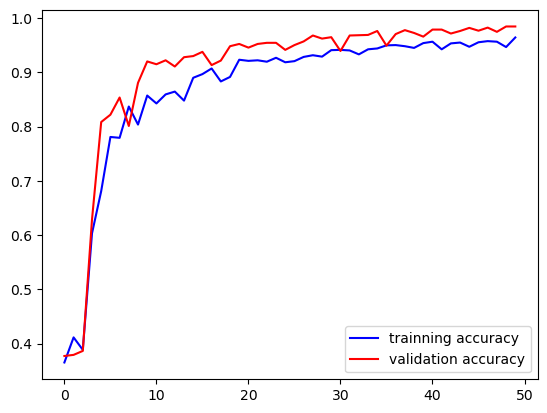

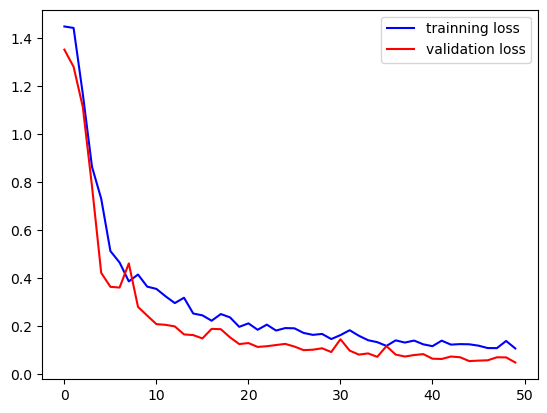

In [144]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

saving the model.

In [157]:
model.save("drowiness_new6.h5")
model.save("drowiness_new6.model")

C:\Users\Khalil\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: drowiness_new6.model\assets


INFO:tensorflow:Assets written to: drowiness_new6.model\assets


predicting function

In [146]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

def prepare(dir_path, face_cas="haar_cascade_files/haarcascade_frontalface_default.xml"):
    IMG_SIZE = 145
    data = []
    for img in os.listdir(dir_path):
        img_array = cv2.imread(os.path.join(dir_path, img), cv2.IMREAD_COLOR)
        img_array = img_array / 255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        data.append( resized_array)
    return data

In [147]:
x_predict = prepare(pred_dir)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(-1, 145, 145, 3)

In [148]:
len(x_predict)

2467

In [149]:
y_predict = model.predict(x_predict)

78/78 [==============================] - 36s 457ms/step


In [150]:
def get_label(n):
    labels = {"yawn":0, "no_yawn":1, "Closed":2, "Open":3}
    for x,y in labels.items():
        if n == y:
            return x

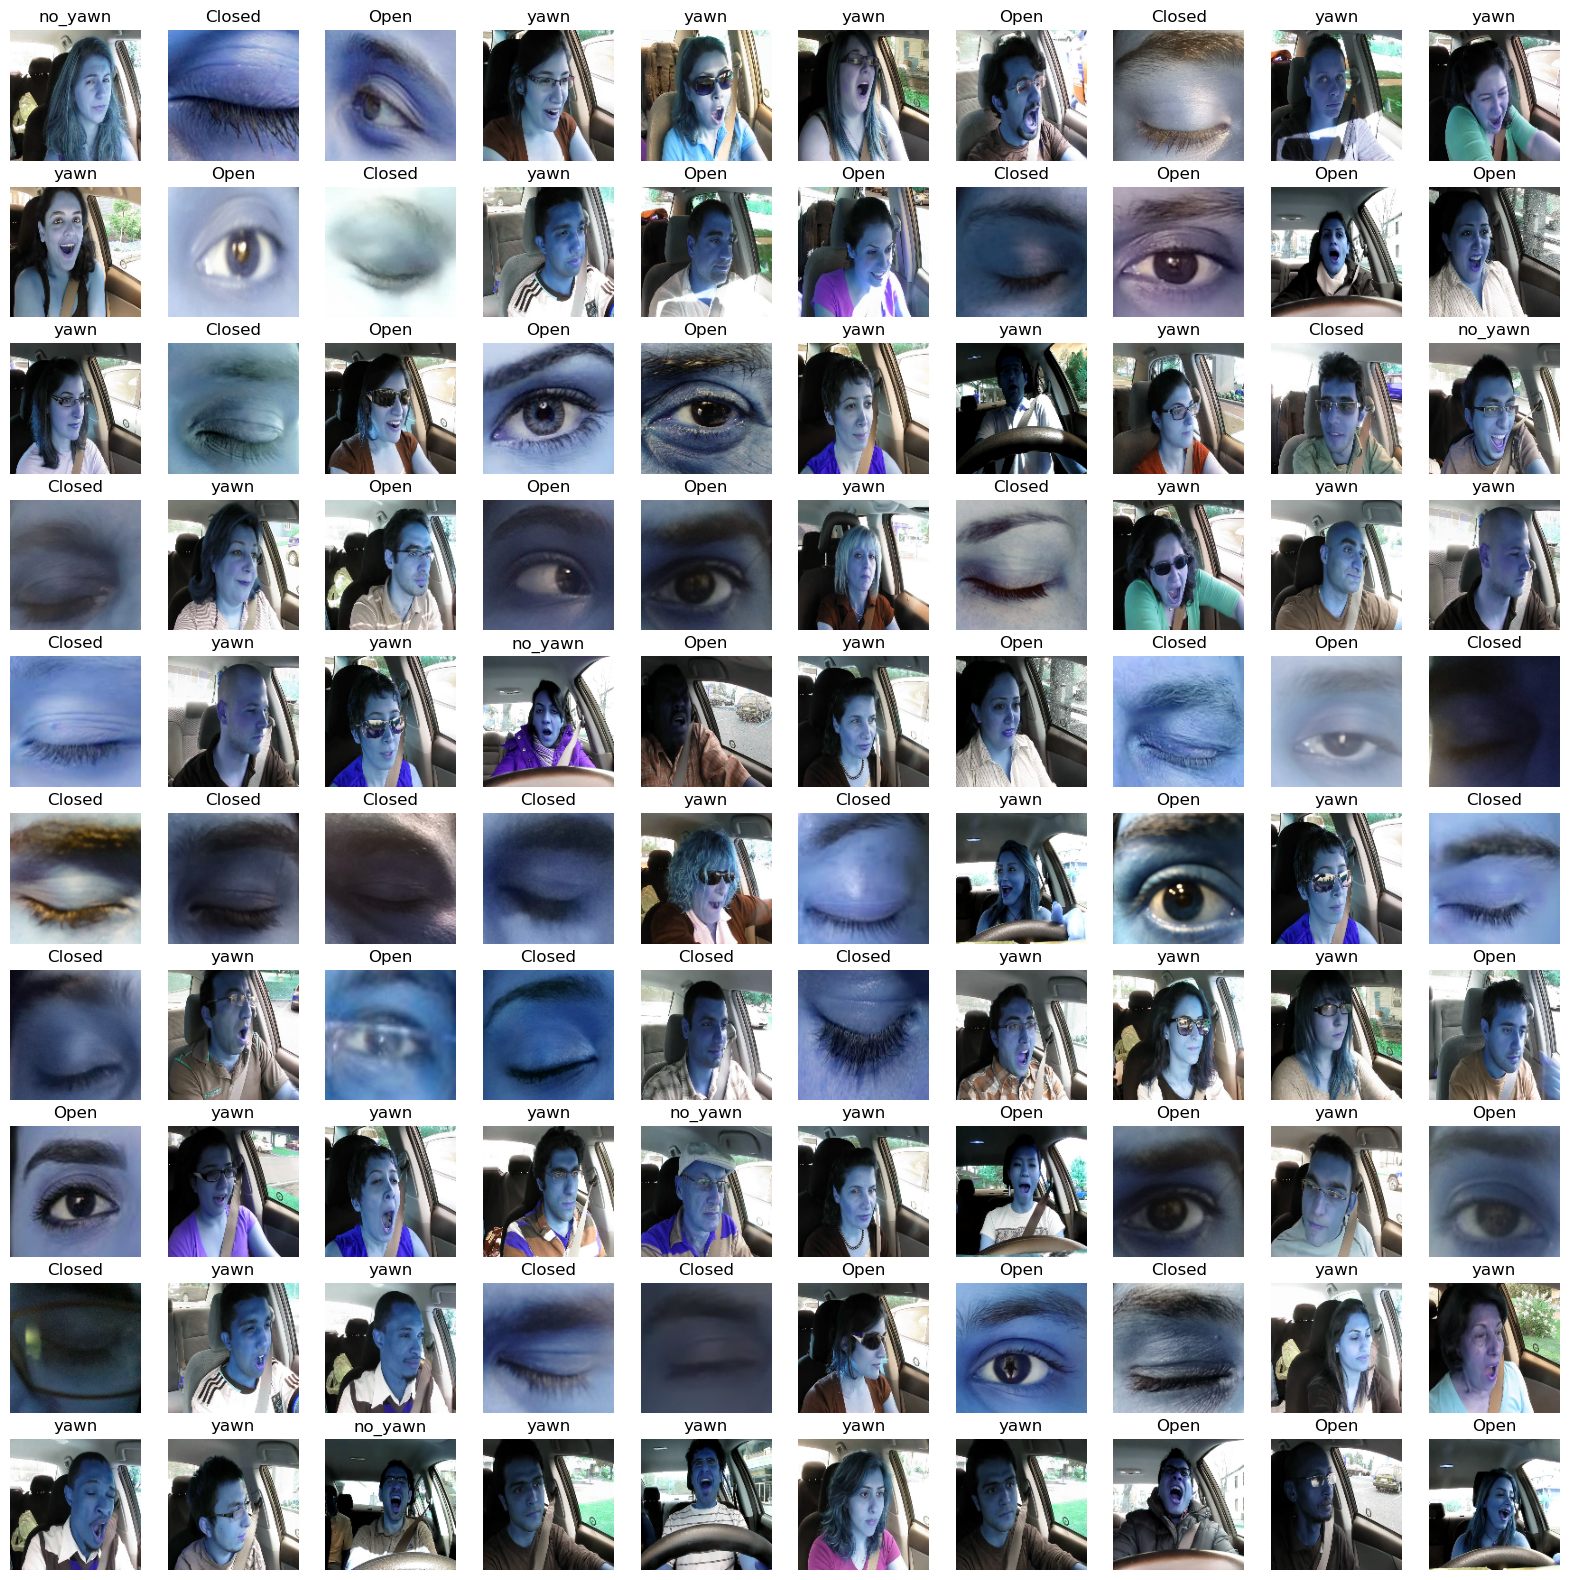

In [156]:
plt.figure(figsize = (20,20))
for n, i in enumerate(list(np.random.randint(0,len(x_predict),100))):
    plt.subplot(10,10, n+1)
    plt.imshow(x_predict[i])
    plt.axis('off')
    plt.title(get_label(np.argmax(y_predict[i])))